In [1]:
import pandas as pd
from scipy import stats
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  

In [3]:
data = pd.read_csv("./Data/Howell1.csv", delimiter=";")

In [4]:
d2 = data[data.age >= 18]

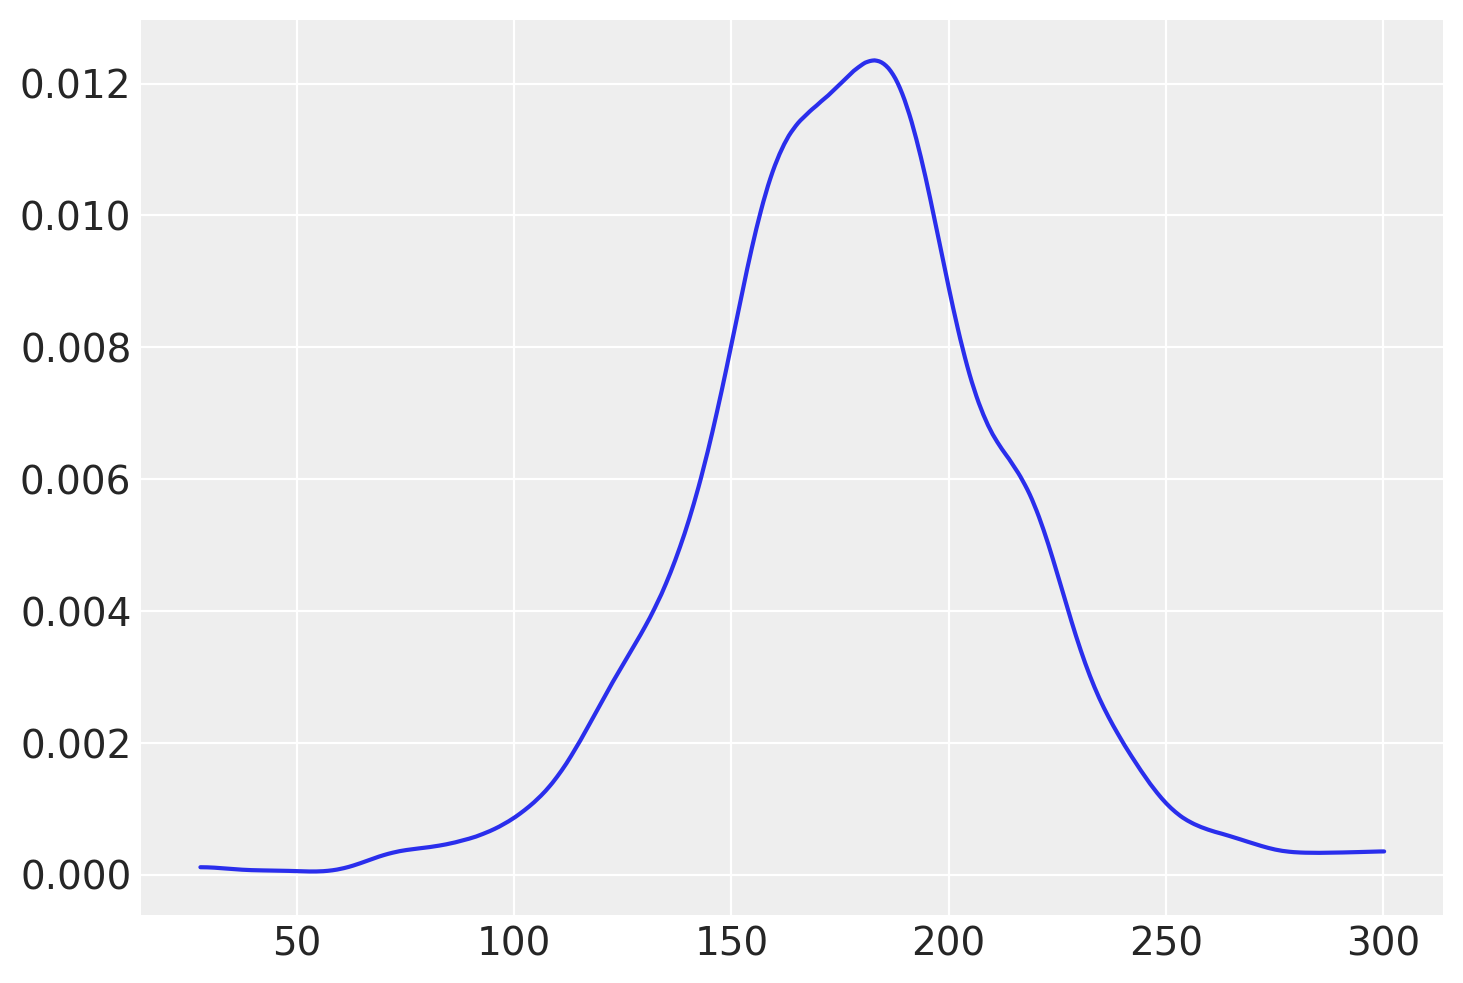

In [16]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h);

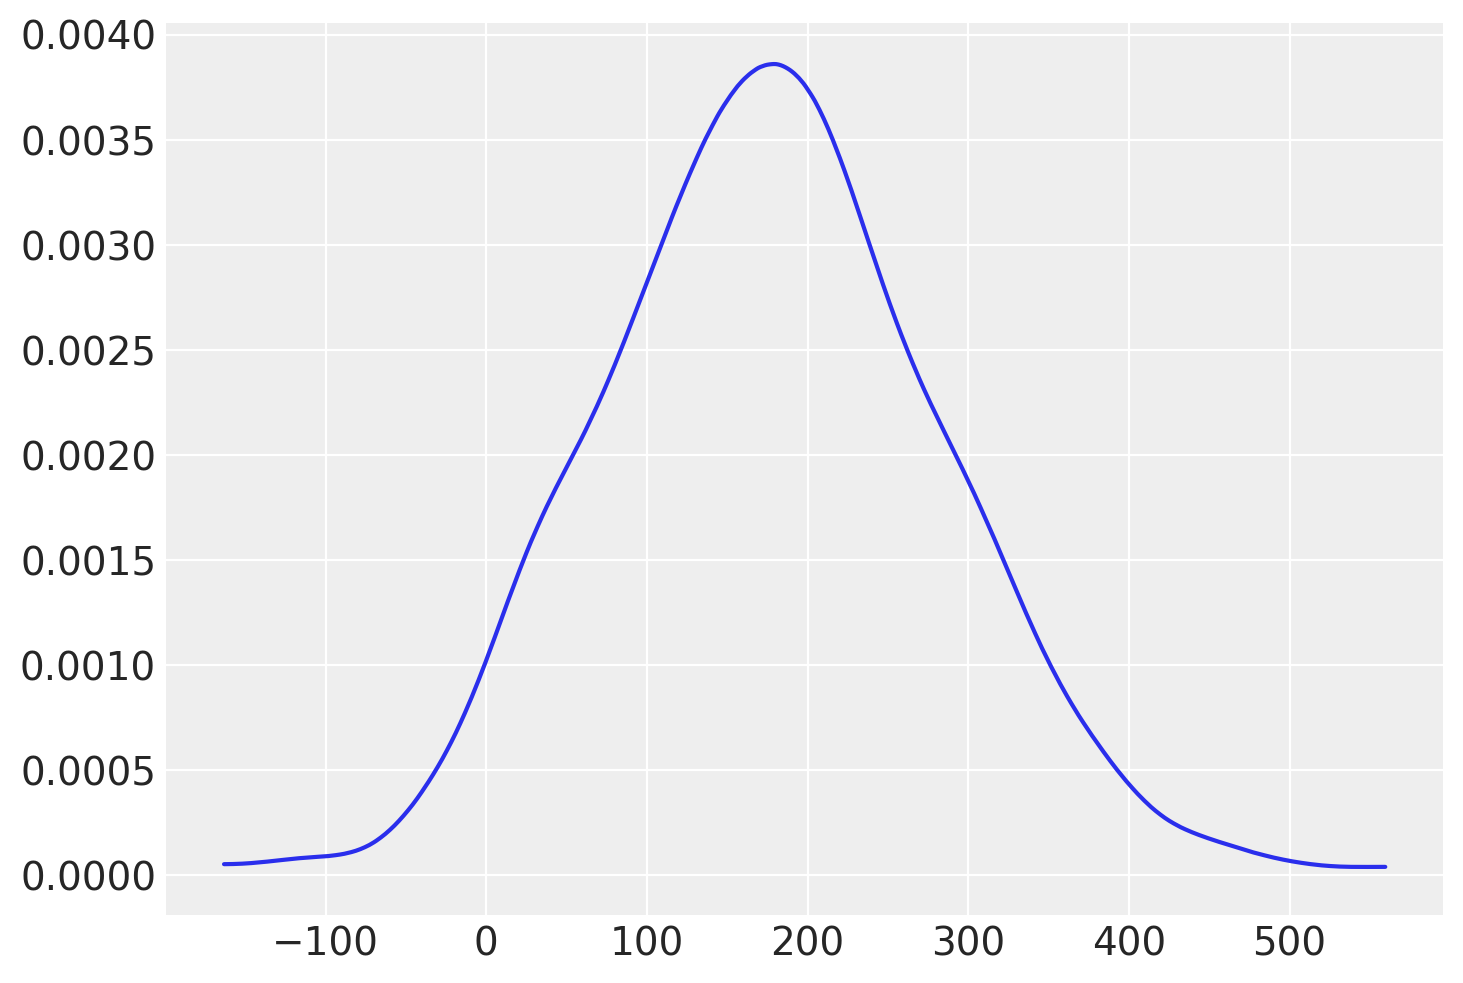

In [17]:
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h);

In [6]:
with pm.Model() as height_model:
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    
with height_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [26]:
az.summary(trace, round_to=2, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.60,0.42,153.96,155.28
sigma,7.77,0.29,7.30,8.24


In [7]:
az.summary(trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.612,0.410,153.919,155.220,0.007,0.005,3617.0,2790.0,1.0
sigma,7.773,0.298,7.293,8.228,0.005,0.004,3629.0,2831.0,1.0


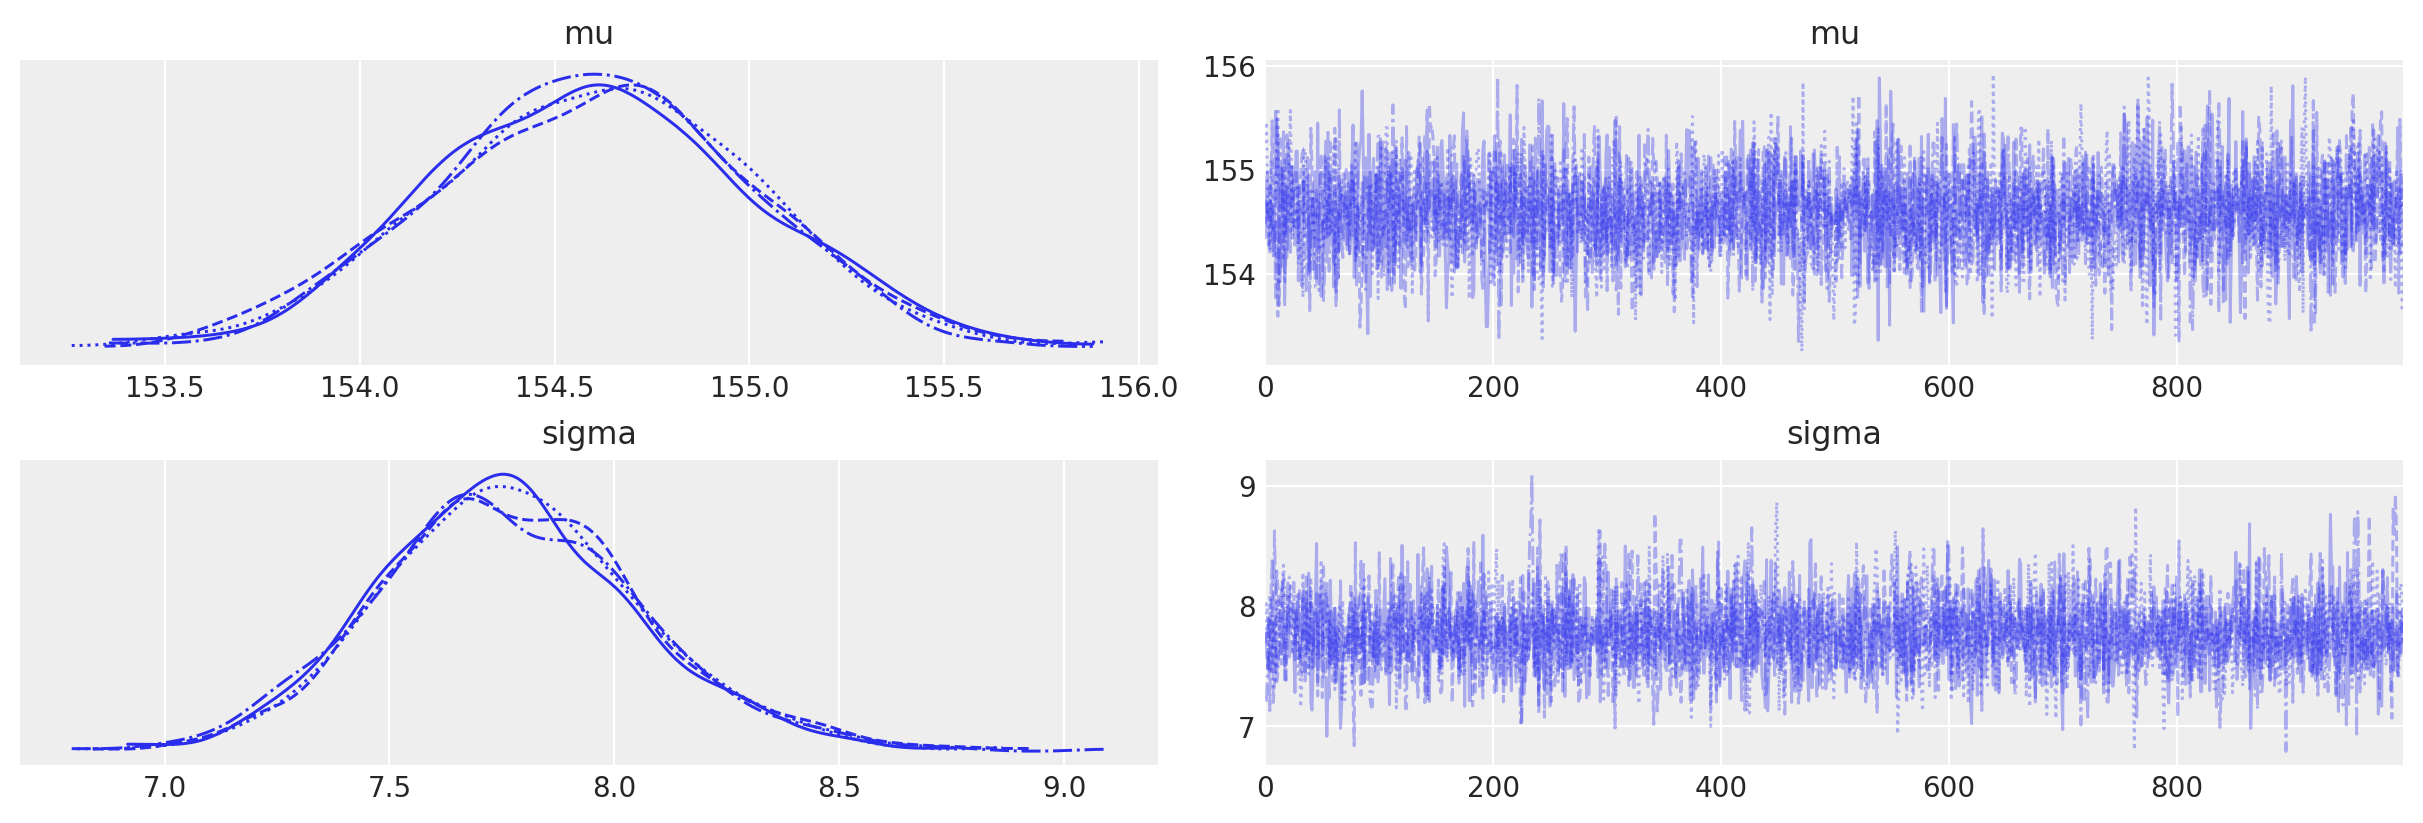

In [30]:
az.plot_trace(trace);

In [32]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_1 = pm.sample(1000, tune=1000)

/tmp/ipykernel_1425/3363333656.py:2: FutureWarning: The `testval` argument is deprecated; use `initval`.
  mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
/tmp/ipykernel_1425/3363333656.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [33]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sigma=.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    
with m4_2:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [34]:
trace_df = az.extract_dataset(trace).to_dataframe()
trace_df.cov()

/tmp/ipykernel_1425/1507440975.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  trace_df = az.extract_dataset(trace).to_dataframe()


,mu,sigma,chain,draw
mu,0.009864,0.007757,0.002845,-0.544664
sigma,0.007757,0.922159,0.027879,-7.137681
chain,0.002845,0.027879,1.250313,0.000000
draw,-0.544664,-7.137681,0.000000,83354.088522


In [39]:
trace_df.sigma[0]

draw
0      25.027192
1      24.839433
2      25.398160
3      23.210878
4      24.642703
         ...    
995    24.269006
996    24.817535
997    24.515952
998    25.093714
999    24.880626
Name: sigma, Length: 1000, dtype: float64

In [8]:
xbar = d2.weight.mean()

with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    mu = a + b*(d2.weight - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    trace_4_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [9]:
az.summary(trace_4_3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,154.597,0.269,154.175,155.035,0.004,0.003,5689.0,3032.0,1.0
b,0.903,0.044,0.835,0.973,0.001,0.000,6258.0,3187.0,1.0
sigma,5.102,0.195,4.808,5.422,0.003,0.002,5418.0,3168.0,1.0


In [17]:
trace_df = az.extract(trace_4_3).to_dataframe()
trace_df[["a", "b", "sigma"]].cov()

,a,b,sigma
a,0.074389,0.000115,0.000728
b,0.000115,0.001857,-0.000172
sigma,0.000728,-0.000172,0.037195


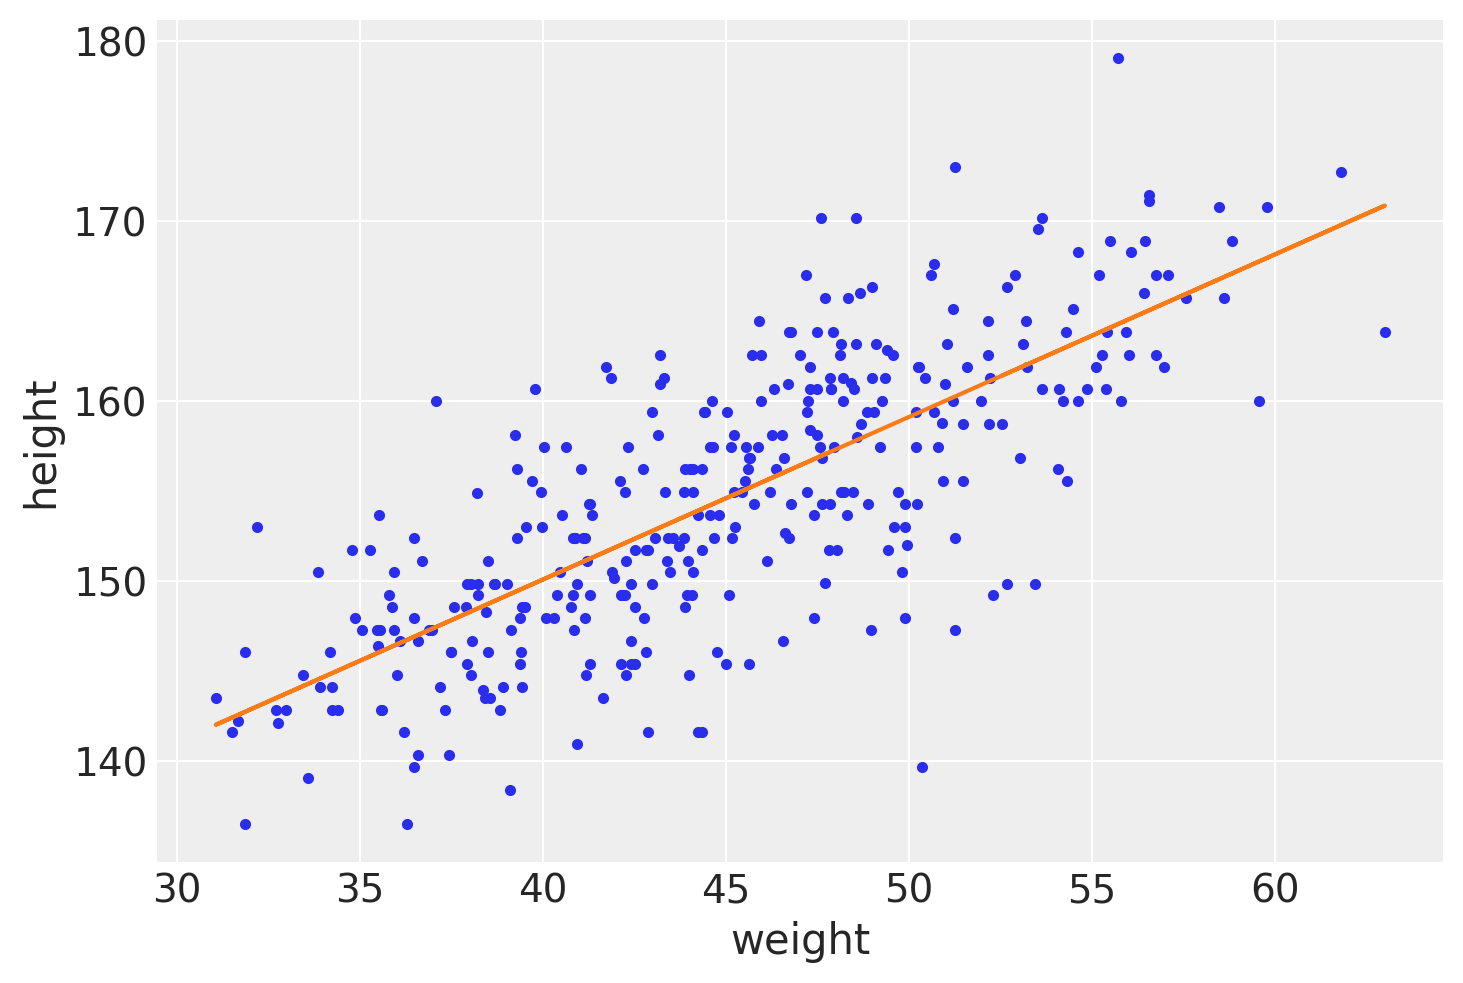

In [20]:
plt.plot(d2.weight, d2.height, ".")
plt.plot(
    d2.weight,
    trace_4_3.posterior["a"].mean().item(0)
    + trace_4_3.posterior["b"].mean().item(0) * (d2.weight - xbar),
)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

In [57]:
n = 175
dn = d2.iloc[:n, :]
xbar = dn.weight.mean()

with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    mu = pm.Deterministic("mu", a + b*(dn.weight - xbar))
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=dn.height)
    trace_4_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


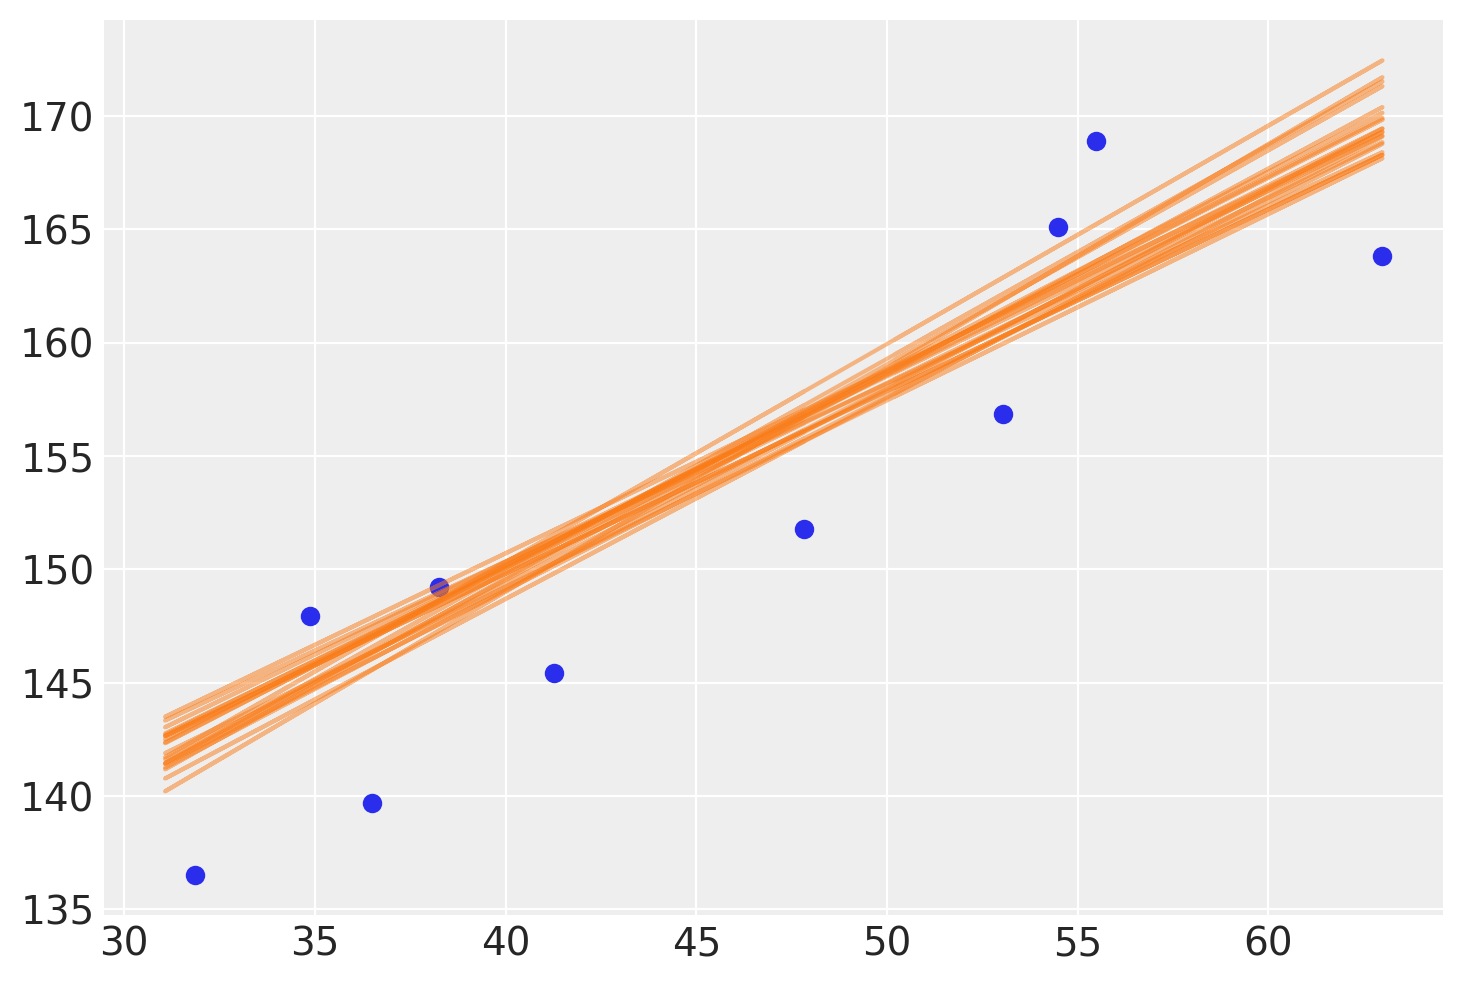

In [59]:
plt.plot(dn.weight[:10], dn.height[:10], "C0o")

trace_df = az.extract(trace_4_3)
n_samples = trace_df.sizes["sample"]
height_rng = np.random.default_rng(2971)
idxs = height_rng.integers(n_samples, size=20)

for idx in idxs:
    plt.plot(
        dn.weight, trace_df["mu"][:, idx],
        "C1-",
        alpha=0.5,
    )

In [54]:
trace_df = az.extract(trace_4_3) # back to full data model
mu_at_50 = trace_df["a"] + trace_df["b"]*(50 - d2.weight.mean())

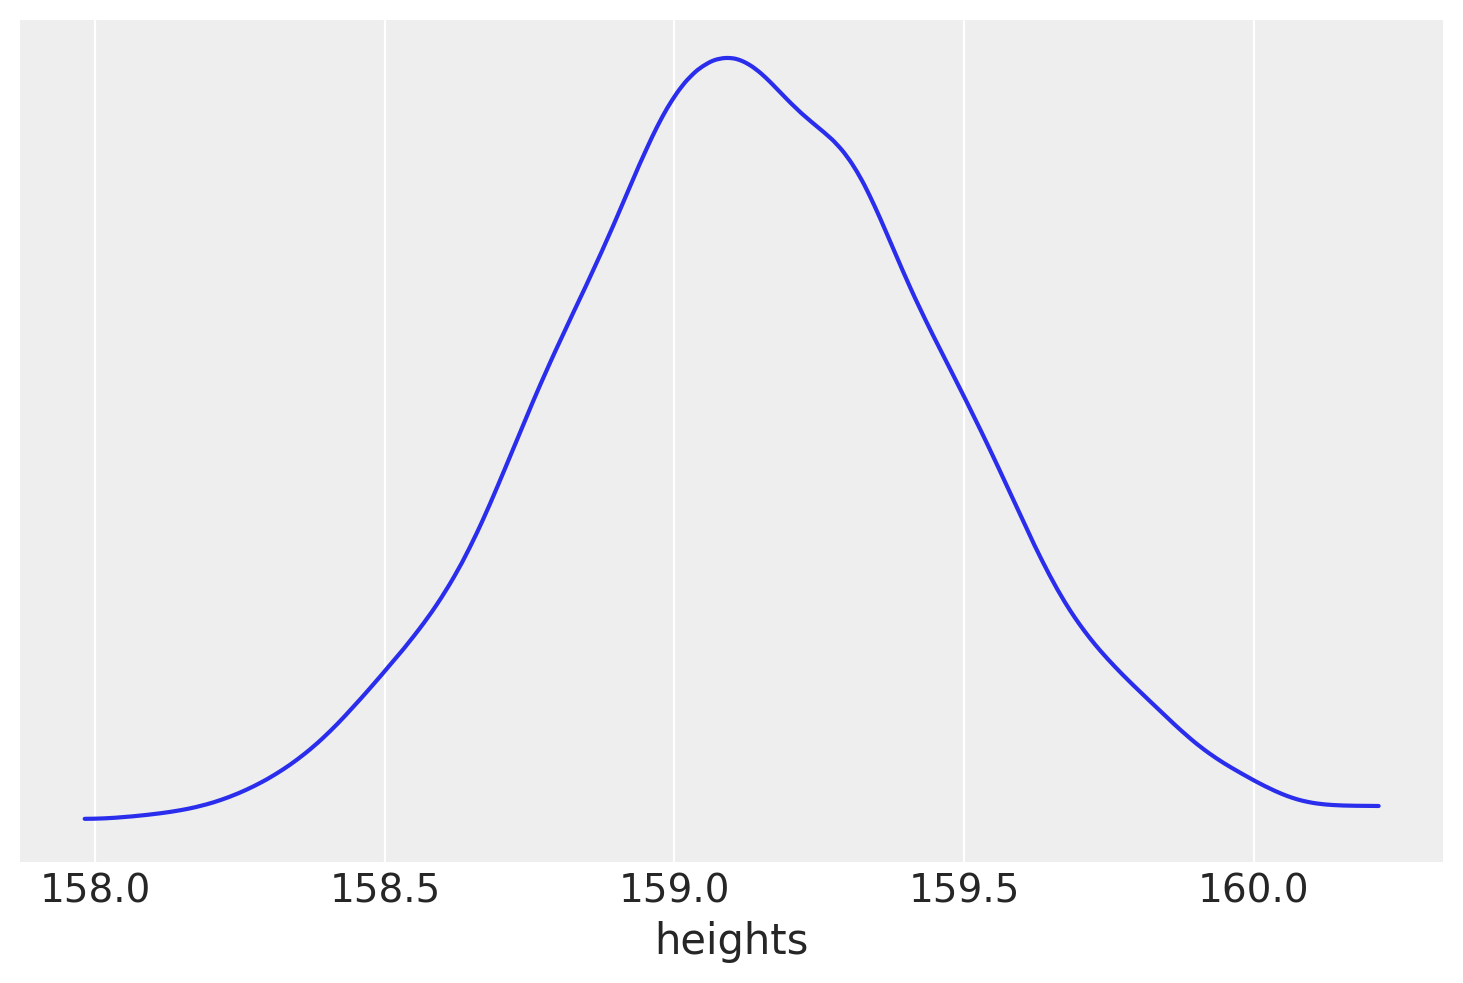

In [56]:
az.plot_kde(mu_at_50.values)
plt.xlabel("heights")
plt.yticks([]);

In [125]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
nb_samples = trace_df.sizes["sample"]
trace_4_3_thinned = trace_df#.isel(sample=range(0, nb_samples, 10))
nb_samples_thinned = trace_4_3_thinned.sizes["sample"]

mu_pred = np.zeros((len(weight_seq), nb_samples_thinned))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_4_3_thinned["a"] + trace_4_3_thinned["b"] * (w - d2.weight.mean())

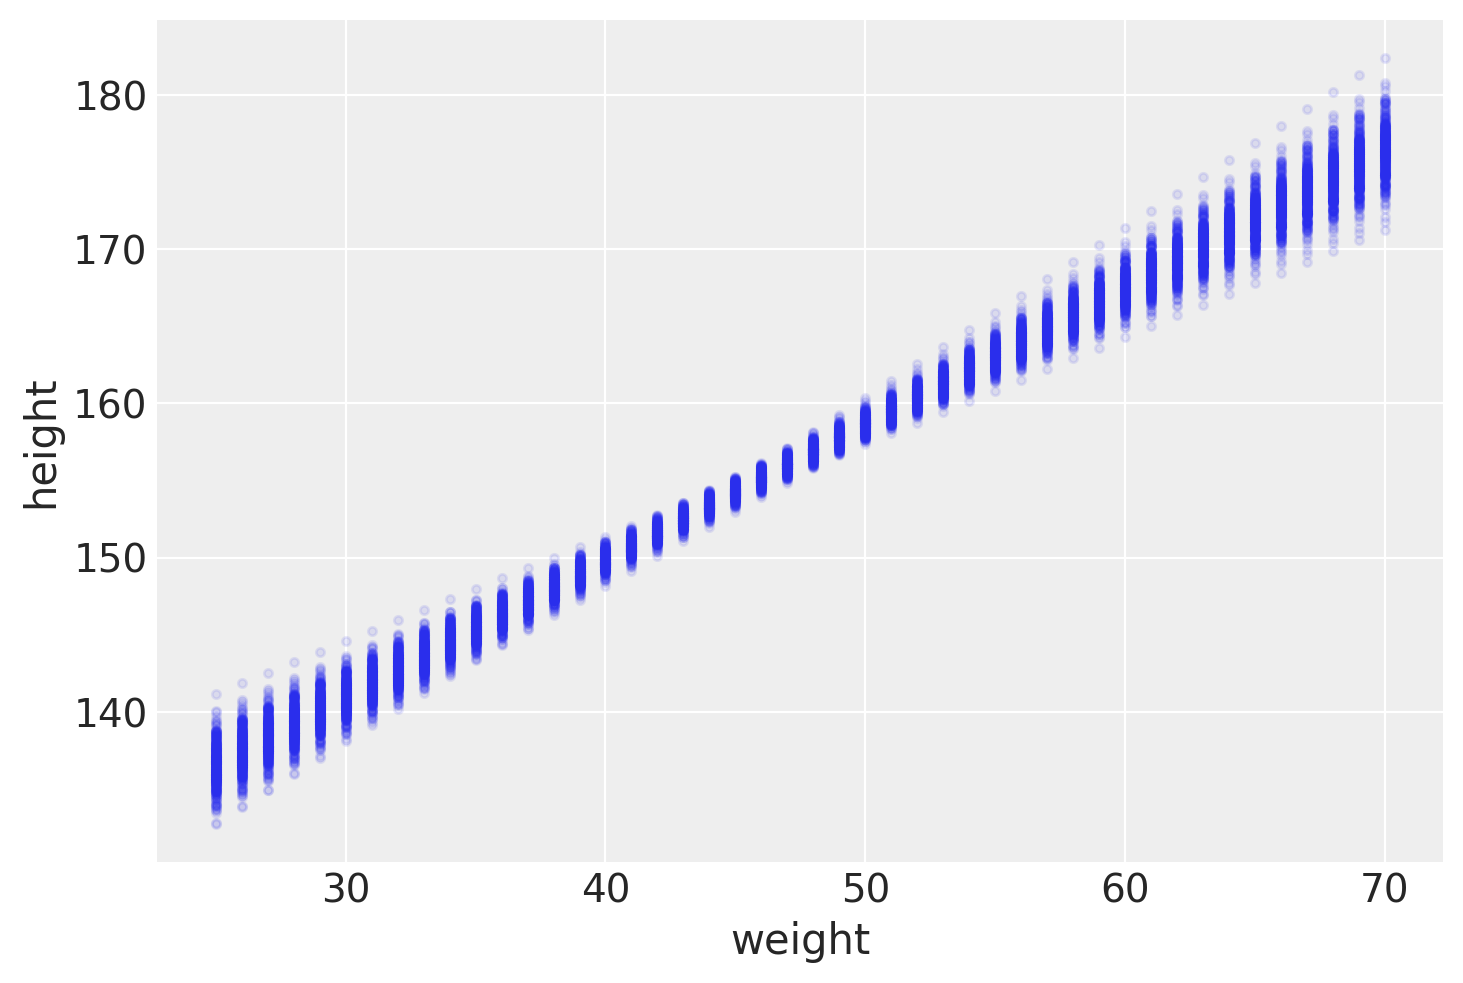

In [61]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

In [62]:
mu_mean = mu_pred.mean(1)
mu_hdi = az.hdi(mu_pred.T)

/tmp/ipykernel_35/2684262116.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi = az.hdi(mu_pred.T)


/home/jaredxfeng/.local/share/virtualenvs/rethinking-JoO_cdOo/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


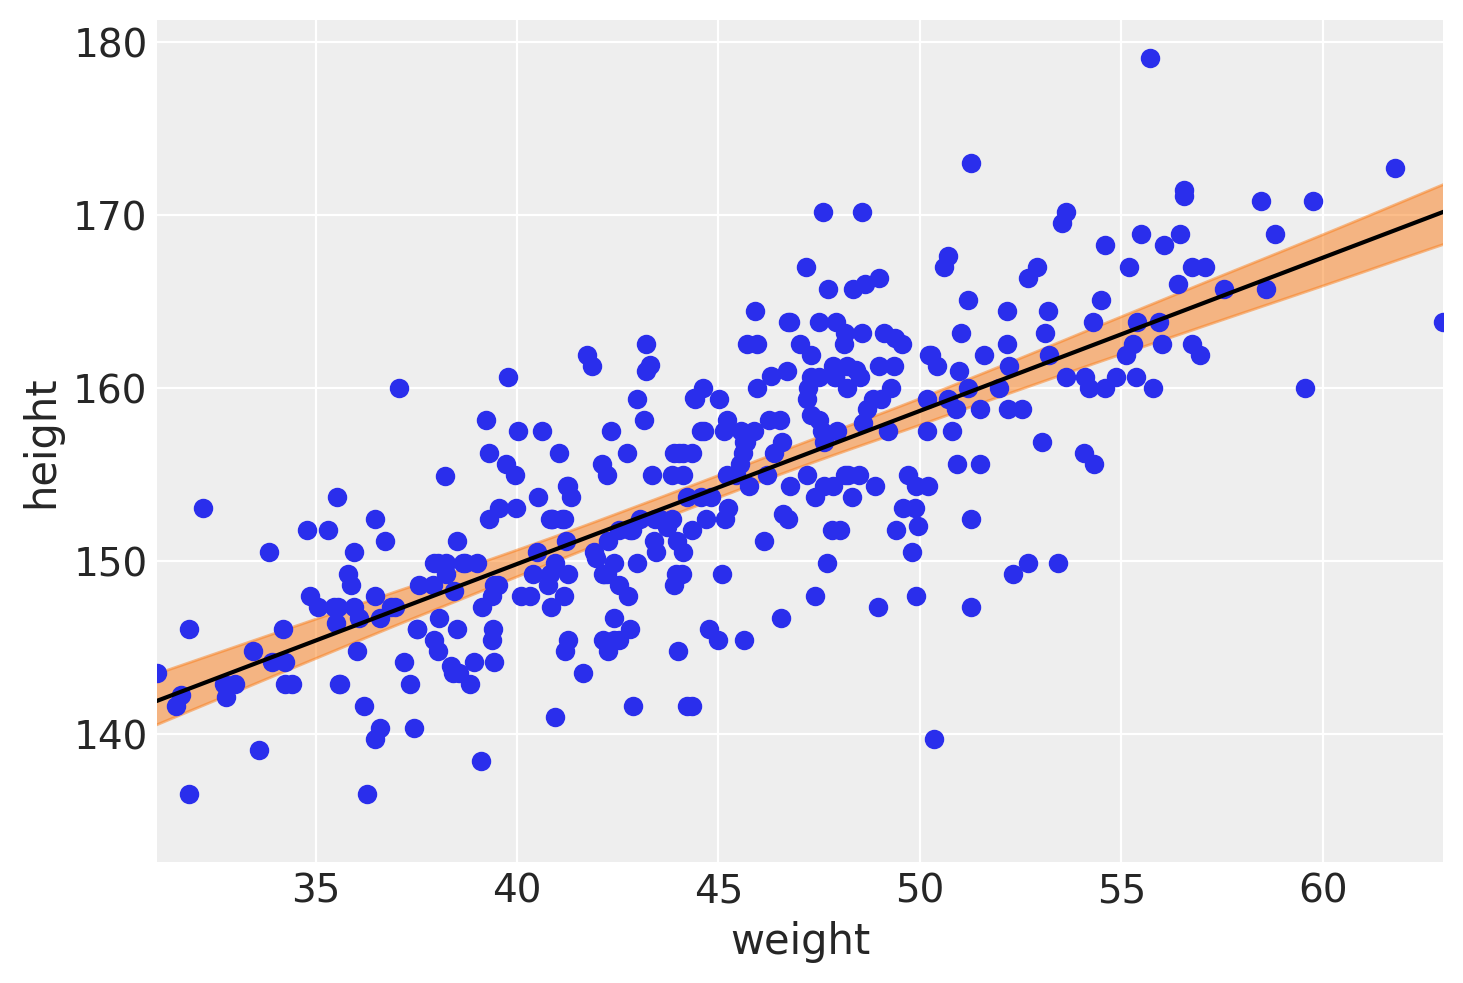

In [69]:
az.plot_hdi(weight_seq, mu_pred.T)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

In [74]:
trace_4_3

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [122]:
thinned_idata = trace_4_3.sel(draw=slice(None, None, 100))
#thinned_idata = trace_4_3
with m4_3:
    height_pred = pm.sample_posterior_predictive(thinned_idata)

Sampling: [height]


In [123]:
height_pred_hdi = az.hdi(height_pred.posterior_predictive["height"])

/home/jaredxfeng/.local/share/virtualenvs/rethinking-JoO_cdOo/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


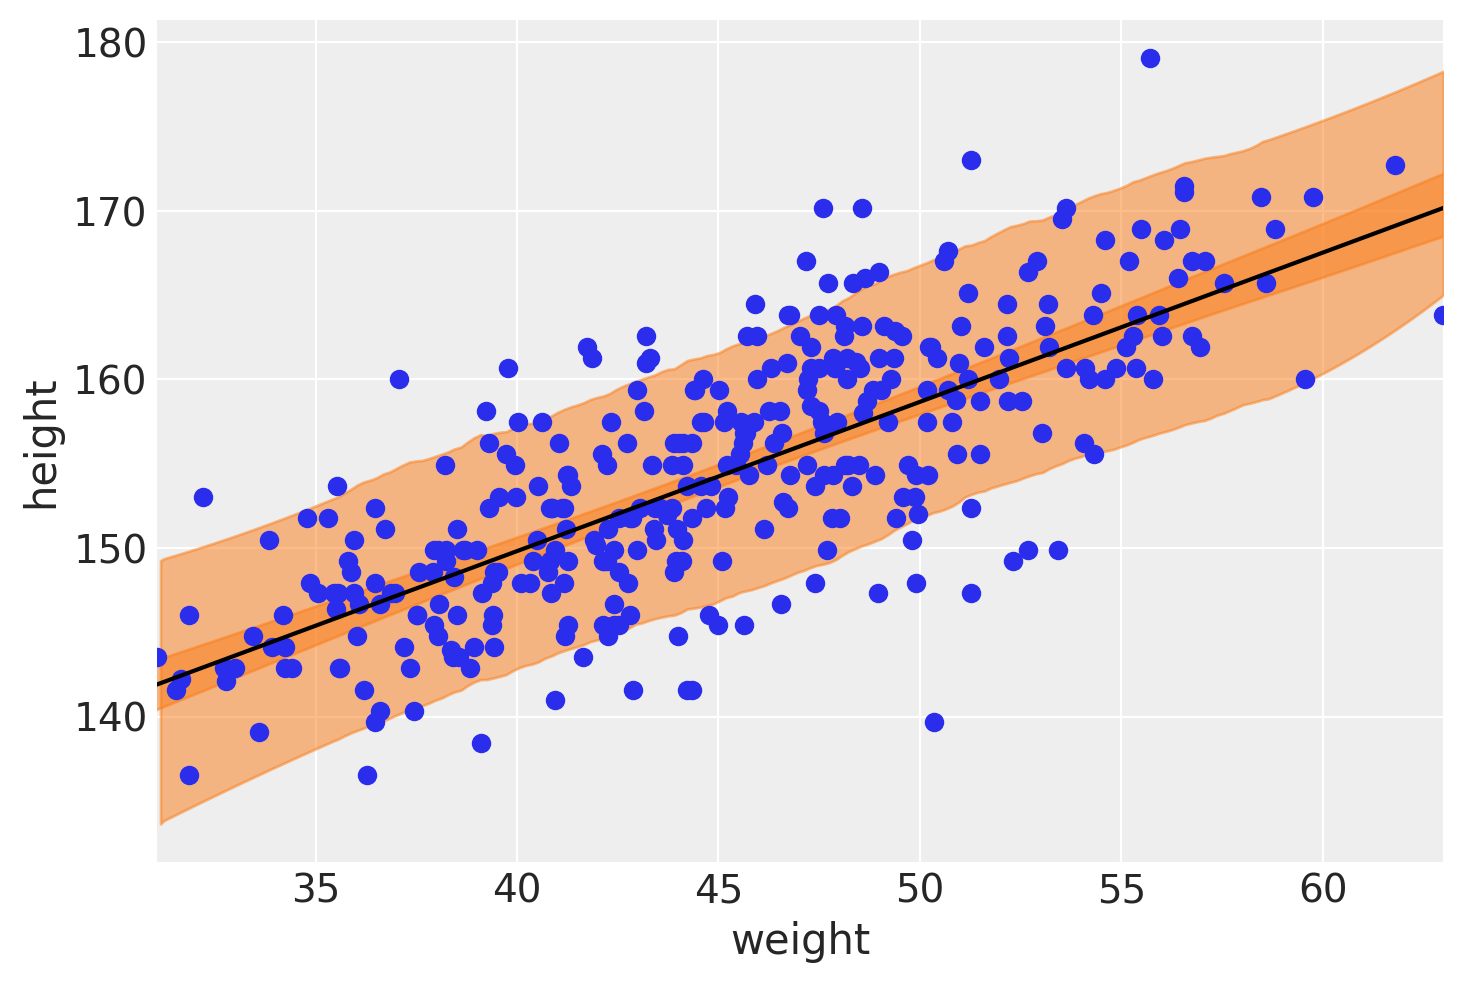

In [126]:
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(d2.weight, height_pred.posterior_predictive["height"], ax=ax)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

In [128]:
data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [ ]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std**2